# 1. Bootstraping

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.utils import resample

In [2]:
# Loading dataset
data = pd.read_csv(r'C:\Users\Usuario\Downloads\penn_jae.csv')

In [55]:
print(data.head())

   Unnamed: 0   abdt  tg  inuidur1  inuidur2  female  black  hispanic  \
0           1  10824   0        18        18       0      0         0   
1           2  10635   2         7         3       0      0         0   
2           3  10551   5        18         6       1      0         0   
3           4  10824   0         1         1       0      0         0   
4           5  10747   0        27        27       0      0         0   

   othrace  dep  ...  q5  q6  recall  agelt35  agegt54  durable  nondurable  \
0        0    2  ...   1   0       0        0        0        0           0   
1        0    0  ...   0   0       0        1        0        0           0   
2        0    0  ...   0   0       1        0        1        0           0   
3        0    0  ...   1   0       0        0        0        0           0   
4        0    0  ...   0   0       0        0        0        0           0   

   lusd  husd  muld  
0     0     1     0  
1     1     0     0  
2     0     0     0 

In [56]:
# Filtering data for treatment (tg == 4) and control (tg == 0)
data_filtered = data[data['tg'].isin([0, 4])].copy()

In [57]:
# Creating T4 variable
data_filtered['T4'] = (data_filtered['tg'].isin([0, 4])).astype(int)

print(data_filtered.head())

    Unnamed: 0   abdt  tg  inuidur1  inuidur2  female  black  hispanic  \
0            1  10824   0        18        18       0      0         0   
3            4  10824   0         1         1       0      0         0   
4            5  10747   0        27        27       0      0         0   
11          12  10607   4         9         9       0      0         0   
12          13  10831   0        27        27       0      0         0   

    othrace  dep  ...  q6  recall  agelt35  agegt54  durable  nondurable  \
0         0    2  ...   0       0        0        0        0           0   
3         0    0  ...   0       0        0        0        0           0   
4         0    0  ...   0       0        0        0        0           0   
11        0    0  ...   0       0        1        0        0           0   
12        0    1  ...   0       0        0        1        1           0   

    lusd  husd  muld  T4  
0      0     1     0   1  
3      1     0     0   1  
4      1     0   

In [58]:
# Creating formula
formula = 'np.log(inuidur1) ~ T4 + female + black + othrace + C(dep) + q2 + q3 + q4 + q5 + q6 + agelt35 + agegt54 + durable + lusd + husd'

In [59]:
# Defining bootstrap function
def bootstrap(data, formula, n_iterations=1000):
    estimates = {'T4': [], 'female': [], 'black': []}
    
    for _ in range(n_iterations):
        # Resample data
        sample = resample(data)
        
        # Adjusting model to get coefficients
        model = sm.formula.ols(formula=formula, data=sample).fit()
        
        # Storing coefficient estimates 
        for var in estimates:
            estimates[var].append(model.params[var])
    
    # Mean standard errors and coefficients
    results = {var: {'Coefficient': np.mean(estimates[var]), 'Bootstrap SE': np.std(estimates[var])} for var in estimates}
    
    return results

In [60]:
# Bootstrapping standard errors and coefficients
bootstrap_results = bootstrap(data_filtered, formula)

In [61]:
# Table with results
results_df = pd.DataFrame(bootstrap_results).T

print(results_df)

        Coefficient  Bootstrap SE
T4         1.080237      0.078145
female     0.125303      0.036137
black     -0.295964      0.058628


# 2. Causal Forest

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
from scipy import stats
from econml.grf import RegressionForest
from econml.dml import CausalForestDML
import patsy
import warnings

In [141]:
# Loading dataset
df = pd.read_csv(r'C:\Users\Usuario\Downloads\synthetic_data.csv')

### How the tree was built?

In [142]:
# 1.1 Data treatment

# Convert 'schoolid' to categorical
df['schoolid'] = pd.Categorical(df['schoolid'])
school_id = df['schoolid'].cat.codes.values

# Define variables
W = df['Z'].values
Y = df['Y'].values
X_raw = df.drop(columns=['Z', 'Y'])

# Encode categorical variables
enc = OneHotEncoder(drop='first', sparse=False)
C1_exp = enc.fit_transform(X_raw[['C1']])
XC_exp = enc.fit_transform(X_raw[['XC']])

X = np.hstack((X_raw.drop(columns=['C1', 'XC']).values, C1_exp, XC_exp))

# 1.2 Causal Forest

# Forest growth
Y_forest = RegressionForest()
Y_forest.fit(X, Y)
Y_hat = Y_forest.predict(X)

W_forest = RegressionForest()
W_forest.fit(X, W)
W_hat = W_forest.predict(X)

# Fit Causal Forest
cf = CausalForestDML(model_y=Y_forest,
                     model_t=W_forest,
                     discrete_treatment=False,
                     random_state=1)
cf.fit(Y, W, X=X)
tau_hat = cf.effect(X)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


### Estimate ATE

In [143]:
ate = cf.ate(X)
ate_ci = cf.ate_interval(X)
print(f"95% CI for the ATE: {ate:.3f} +/- {1.96 * (ate_ci[1] - ate):.3f}")

95% CI for the ATE: 0.250 +/- 0.477


### Best linear predictor analysis

In [144]:
def test_calibration(cf, X, Y, W, n_folds=5, alpha=0.05):
    n = len(Y)
    tau_hat = np.zeros(n)
    Y_hat = np.zeros(n)
    W_hat = np.zeros(n)

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        W_train, W_test = W[train_index], W[test_index]

        cf_fold = cf.fit(X_train, Y_train, W_train)
        tau_hat[test_index] = cf_fold.predict(X_test)
        Y_hat[test_index] = cf_fold.predict_expected_outcome(X_test)
        W_hat[test_index] = cf_fold.propensity_scores_

    # Calculate DR scores
    dr_scores = tau_hat + W / W_hat * (Y - Y_hat - (1 - W_hat) * tau_hat) - \
                (1 - W) / (1 - W_hat) * (Y - Y_hat + W_hat * tau_hat)

    # Group division based on quantiles
    quantiles = np.quantile(tau_hat, [0.2, 0.4, 0.6, 0.8])
    groups = np.digitize(tau_hat, quantiles)

    # Treatment effect per group
    group_ates = [np.mean(dr_scores[groups == i]) for i in range(1, 6)]
    group_tau_hats = [np.mean(tau_hat[groups == i]) for i in range(1, 6)]

    # SE per group
    group_ses = [np.std(dr_scores[groups == i]) / np.sqrt(np.sum(groups == i)) for i in range(1, 6)]

    # CI
    z = stats.norm.ppf(1 - alpha / 2)
    lower_bounds = [ate - z * se for ate, se in zip(group_ates, group_ses)]
    upper_bounds = [ate + z * se for ate, se in zip(group_ates, group_ses)]

    print("Calibration Test Results:")
    print("Group\tTau_hat\tATE\t95% CI")
    for i in range(5):
        print(f"{i+1}\t{group_tau_hats[i]:.3f}\t{group_ates[i]:.3f}\t[{lower_bounds[i]:.3f}, {upper_bounds[i]:.3f}]")

    # Hypothesis
    null_hypothesis = all(lower <= tau <= upper for tau, lower, upper in zip(group_tau_hats, lower_bounds, upper_bounds))
    print(f"\nNull Hypothesis (all ATEs within CI): {'Fail to Reject' if null_hypothesis else 'Reject'}")
    
    return tau_hat

In [145]:
def best_linear_predictor_analysis(cf, X, tau_hat):
    high_effect = tau_hat > np.median(tau_hat)
    ate_high = cf.ate(X[high_effect])
    ate_low = cf.ate(X[~high_effect])
    diff = ate_high - ate_low
    diff_ci = norm.ppf(0.975) * np.sqrt(cf.ate_interval(X[high_effect])[1]**2 + cf.ate_interval(X[~high_effect])[1]**2)
    
    print(f"95% CI for difference in ATE: {diff:.3f} +/- {diff_ci:.3f}")

cf = CausalForestDML(model_y=RandomForestRegressor(),
                     model_t=RandomForestRegressor(),
                     discrete_treatment=False,
                     random_state=1)
cf.fit(Y, W, X=X)
tau_hat = cf.effect(X)

best_linear_predictor_analysis(cf, X, tau_hat)

95% CI for difference in ATE: 0.233 +/- 1.443


### Formal test for X1 and X2

In [146]:
# Calculate dr_score
dr_score = tau_hat + W / cf['W_hat'] * (Y - cf['Y_hat'] - (1 - cf['W_hat']) * tau_hat) - \
           (1 - W) / (1 - cf['W_hat']) * (Y - cf['Y_hat'] + cf['W_hat'] * tau_hat)

# Calculate school_score
school_score = np.dot(school_mat.T, dr_score) / school_size

# Calculate school.X1
school_X1 = np.dot(school_mat.T, X['X1']) / school_size
high_X1 = school_X1 > np.median(school_X1)
t_test_X1 = ttest_ind(school_score[high_X1], school_score[~high_X1])

# Calculate school.X2
school_X2 = np.dot(school_mat.T, X['X2']) / school_size
high_X2 = school_X2 > np.median(school_X2)
t_test_X2 = ttest_ind(school_score[high_X2], school_score[~high_X2])

TypeError: list indices must be integers or slices, not str

### Look at school-wise heterogeneity

In [ ]:
# Calculation of dr_score
dr_score = tau_hat + W / cf.effect(X) * (Y - cf.effect(X) - (1 - cf.effect(X)) * tau_hat) - (1 - W) / (1 - cf.effect(X)) * (Y - cf.effect(X) + cf.effect(X) * tau_hat)

# Calculation of school_score
school_score = np.dot(school_mat.T, dr_score) / school_size

# Filter NaN values from school_score
school_score_filtered = school_score[~np.isnan(school_score)]

# Plot histogram with filtered values
plt.figure(figsize=(8, 6))
plt.hist(school_score_filtered, bins=20, edgecolor='black')
plt.xlabel("School Treatment Effect Estimate")
plt.title("Histogram of School Treatment Effect Estimates")
plt.show()

# Check ATE
ate_hat = np.mean(school_score_filtered)
se_hat = np.sqrt(np.var(school_score_filtered) / (len(school_score_filtered) - 1))
print(round(ate_hat, 3), "+/-", round(1.96 * se_hat, 3))

# View variation in propensity scores
DF = X.copy()
DF['W_hat'] = cf.W_hat

plt.figure(figsize=(8, 6))
DF.boxplot(column='W_hat', by='S3')
plt.xlabel("Student Expectation of Success")
plt.ylabel("Propensity Score")
plt.title("Variation in Propensity Scores by Student Expectation of Success")
plt.show()

### Analysis ignoring clusters

In [147]:
# Train the causal forest model without clustering
cf_noclust = CausalForestDML().fit(Y, T=W, X=X)

# Calculate the average treatment effect (ATE)
ATE_noclust = cf_noclust.effect(X)

# Print the confidence interval for the ATE
print("95% CI for the ATE:", round(ATE_noclust[0], 3),
      "+/-", round(norm.ppf(0.975) * ATE_noclust[1], 3))

# Test the calibration of the model
test_calibration(cf_noclust, X, Y, W.reshape(-1, 1))

# Predict treatment effects for the whole dataset
tau_hat_noclust = cf_noclust.effect(X)

# Plot school.id against predicted treatment effects
plot(school.id, tau_hat_noclust)

nfold = 5
school_levels = np.unique(school_id)
cluster_folds = np.random.choice(nfold, len(school_levels), replace=True)

tau_hat_crossfold = np.empty(len(Y))
for foldid in range(1, nfold+1):
    print(foldid)
    infold = np.isin(school_id, school_levels[cluster_folds == foldid])
    cf_fold = CausalForestDML().fit(Y[~infold], T[~infold], X=X[~infold], W=W[~infold])
    pred_fold = cf_fold.effect(X[infold])
    tau_hat_crossfold[infold] = pred_fold

# Create a copy of the original causal forest model
cf_noclust_cpy = cf_noclust.copy()

# Add crossfold predictions and school clusters to the copy
cf_noclust_cpy.predictions = tau_hat_crossfold
cf_noclust_cpy.clusters = school_id

# Test the calibration of the copy with crossfold predictions
test_calibration(cf_noclust_cpy)

# Calculate R loss for each scenario
R_loss_noclust = np.mean(((Y - Y_hat) - tau_hat * (W - W_hat))**2)
R_loss_noclust_cf = np.mean(((Y - Y_hat) - tau_hat_noclust * (W - W_hat))**2)
R_loss_crossfold = np.mean(((Y - Y_hat) - tau_hat_crossfold * (W - W_hat))**2)

# Print the results
print(R_loss_noclust_cf - R_loss_noclust, R_loss_crossfold - R_loss_noclust)

model = ols('dr_score ~ C(school_id)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

95% CI for the ATE: 0.295 +/- 0.373


TypeError: CausalForestDML.fit() takes 3 positional arguments but 4 were given

### Analysis without fitting the propensity score

95% CI for the ATE: 0.336 +/- 0.509


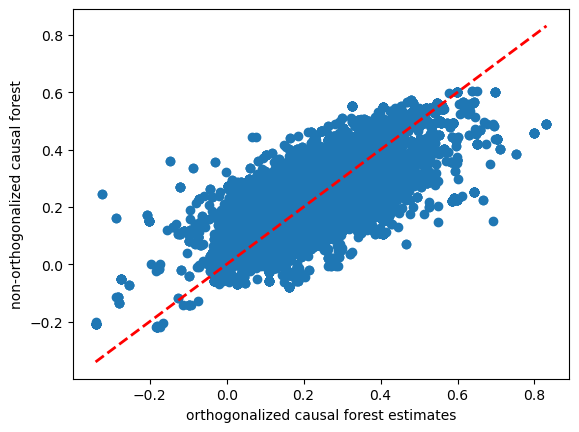

In [148]:
# Train the causal forest model without proportional weighting
cf_noprop = CausalForestDML().fit(Y, T=W, X=X)

# Predict treatment effects for the whole dataset
tau_hat_noprop = cf_noprop.effect(X)

# Calculate the average treatment effect (ATE)
ATE_noprop = cf_noprop.const_marginal_effect(X)

# Print the confidence interval for the ATE
print("95% CI for the ATE:", round(ATE_noprop[0], 3),
      "+/-", round(norm.ppf(0.975) * ATE_noprop[1], 3))

# Plot tau_hat against tau_hat_noprop
plt.figure()
plt.plot(tau_hat, tau_hat_noprop, marker='o', linestyle='None')
plt.xlabel("orthogonalized causal forest estimates")
plt.ylabel("non-orthogonalized causal forest")
plt.plot([min(tau_hat), max(tau_hat)], [min(tau_hat), max(tau_hat)], linestyle='--', linewidth=2, color='r')
plt.savefig("tauhat_noprop.pdf")
plt.show()

### Visualize school-level covariates by treatment heterogeneity

In [149]:
# Calculate school.X
school_X = pd.DataFrame(np.dot(school_mat.T, X[:, [3, 4, 5, 6, 7, 20, 21, 22, 23]]) / school_size)
school_X.columns = ["X1", "X2", "X3", "X4", "X5", "XC.1", "XC.2", "XC.3", "XC.4"]

ValueError: operands could not be broadcast together with shapes (76,9) (76,) 

In [150]:
# Scale the data
scaler = StandardScaler()
school_X_std = scaler.fit_transform(school_X)

# Create terciles
terciles = pd.qcut(school_pred, q=[0, 1/3, 2/3, 1], labels=["low", "mid", "high"])
school_tercile_mat = pd.get_dummies(terciles)

# Calculate conditional means
school_means = np.dot(np.linalg.inv(np.diag(1 / school_tercile_mat.sum(axis=0))),
                      np.dot(school_tercile_mat.T, school_X_std))

# Create the plot
DF_plot = pd.df({
    'tercile': np.repeat(["low", "mid", "high"], 9),
    'mean': school_means.flatten(),
    'feature': np.repeat(school_X.columns, 3)
})

plt.figure(figsize=(8, 4.5))
sns.heatmap(DF_plot.pivot("feature", "tercile", "mean"), cmap="coolwarm", annot=True, fmt=".2f")
plt.savefig("tercile_plot.pdf")

# Calculate the mean of XC.3
print(np.mean(school_X["XC.3"]))
print(np.mean(school_X["XC.3"][terciles == "low"]))

NameError: name 'school_X' is not defined

### CATE by school

In [151]:
# Calcular school.X
school_X = np.dot(school_mat.T, X[:, [3, 4, 5, 6, 7, 24, 25, 26, 27]]) / school_size
school_X = pd.DataFrame(school_X)
school_X.columns = ["X1", "X2", "X3", "X4", "X5", "XC.1", "XC.2", "XC.3", "XC.4"]

# Calcular dr.score
dr_score = tau_hat + W / cf.W_hat * (Y - cf.Y_hat - (1 - cf.W_hat) * tau_hat) - \
           (1 - W) / (1 - cf.W_hat) * (Y - cf.Y_hat + cf.W_hat * tau_hat)

# Calcular school.score
school_score = np.dot(school_mat.T, dr_score) / school_size

# Entrenar el bosque aleatorio
school_forest = RandomForestRegressor()
school_forest.fit(school_X, school_score)

# Realizar predicciones
school_pred = school_forest.predict(school_X)

# Probar la calibración del modelo
test_calibration(school_forest)

IndexError: index 27 is out of bounds for axis 1 with size 27

In [152]:
ord = np.argsort(np.argsort(school_pred))
school_sort = ord[school_id]

plt.figure()
plt.boxplot(tau_hat_noclust, positions=school_sort, widths=0.6)
plt.scatter(np.arange(1, 77), np.sort(school_pred), color='red', marker='o', label='school mean CATE')
plt.xlabel('school')
plt.ylabel('estimated CATE')
plt.legend(loc='upper left')
plt.savefig("school_boxplot.pdf")
plt.show()

NameError: name 'school_pred' is not defined